# entrainement arbre de decision #

# imports #

In [51]:
import torch
import numpy as np
import os
import joblib

## import du dataset ##
on utilise encore des .pt alors que c'est pas necessaire pour rester général par rapport au mlp => on multiplie pas les datasets

In [52]:

root = "./dataset/"
inputs = []
targets = []
for dirpath, dirnames, filenames in os.walk(root):
    for filename in filenames:
        if filename.endswith(".pt"):

                path = root + "/" + filename
                print(path)
                data = torch.load(path,weights_only=False)
                input_array = data["input"]
                print(np.shape(input_array))
                input = input_array.reshape(-1)
                input = input.numpy()
                target = data["output"]
                target = target.numpy()
                inputs.append(input)
                targets.append(target)
X = np.stack(inputs)
y = np.stack(targets)
print(np.shape(X))
print(y)

./dataset//25_07_0705_15_00.pt
torch.Size([343])
./dataset//25_07_0705_30_00.pt
torch.Size([343])
./dataset//25_07_0705_45_00.pt
torch.Size([343])
./dataset//25_07_0706_00_00.pt
torch.Size([343])
./dataset//25_07_0706_15_00.pt
torch.Size([343])
./dataset//25_07_0706_30_00.pt
torch.Size([343])
./dataset//25_07_0706_45_00.pt
torch.Size([343])
./dataset//25_07_0707_15_00.pt
torch.Size([343])
./dataset//25_07_0707_30_00.pt
torch.Size([343])
./dataset//25_07_0707_45_00.pt
torch.Size([343])
./dataset//25_07_0708_00_00.pt
torch.Size([343])
./dataset//25_07_0708_15_00.pt
torch.Size([343])
./dataset//25_07_0708_30_00.pt
torch.Size([343])
./dataset//25_07_0708_45_00.pt
torch.Size([343])
./dataset//25_07_0709_00_00.pt
torch.Size([343])
./dataset//25_07_0709_15_00.pt
torch.Size([343])
./dataset//25_07_0709_30_00.pt
torch.Size([343])
./dataset//25_07_0709_45_00.pt
torch.Size([343])
./dataset//25_07_0710_00_00.pt
torch.Size([343])
./dataset//25_07_0710_15_00.pt
torch.Size([343])
./dataset//25_07_071

## séparation données train/test et entrainement de l'arbre multiclass (il y a un arbre par classe ##

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_frac, y_test_frac = train_test_split(X, y, test_size=0.2)
print(X_train, X_test, y_train_frac, y_test_frac )

[[ 60.600006  62.        58.600006 ...  10.36      41.44      51.8     ]
 [ 60.        61.399994  57.80002  ...   0.        72.52      51.8     ]
 [ 69.        72.399994  65.399994 ...  98.556     99.702     98.556   ]
 ...
 [ 70.20001   73.80002   66.80002  ... 100.848    101.994    104.286   ]
 [ 69.600006  73.        66.80002  ...  91.68      95.118     96.264   ]
 [ 62.        64.80002   59.200012 ... 108.87     108.87     105.432   ]] [[ 62.        64.80002   59.200012 ... 111.162    110.016    105.432   ]
 [ 62.600006  66.20001   59.80002  ... 108.87     138.804    142.242   ]
 [ 63.399994  65.399994  61.200012 ... 103.6        0.       134.68    ]
 ...
 [ 62.600006  65.399994  59.80002  ... 108.87     107.724    105.432   ]
 [ 62.600006  64.80002   59.200012 ... 108.87     139.95      97.41    ]
 [ 62.        64.80002   59.200012 ... 107.724    111.162    111.162   ]] [[0.         0.6981     0.6982     0.4666    ]
 [0.         0.6981     0.7038     0.        ]
 [0.5012     0.698

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
y_train = np.zeros(np.shape(y_train_frac))
y_test = np.zeros(np.shape(y_test_frac))
for i in range(len(y_train_frac)):
    for j in range(len(y_train_frac[i])):
        y_train[i][j] = round(y_train_frac[i][j])
for i in range(len(y_test_frac)):
    for j in range(len(y_test_frac[i])):
        y_test[i][j] = round(y_test_frac[i][j])

print(y_train.shape)
print(X_train.shape)
base_tree = DecisionTreeClassifier(max_depth=3)
clf = MultiOutputClassifier(base_tree)
clf.fit(X_train, y_train)


(3112, 4)
(3112, 343)


,estimator,DecisionTreeC...r(max_depth=3)
,n_jobs,None
,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None


## plot des arbres (utilisés dans le streamlit ##

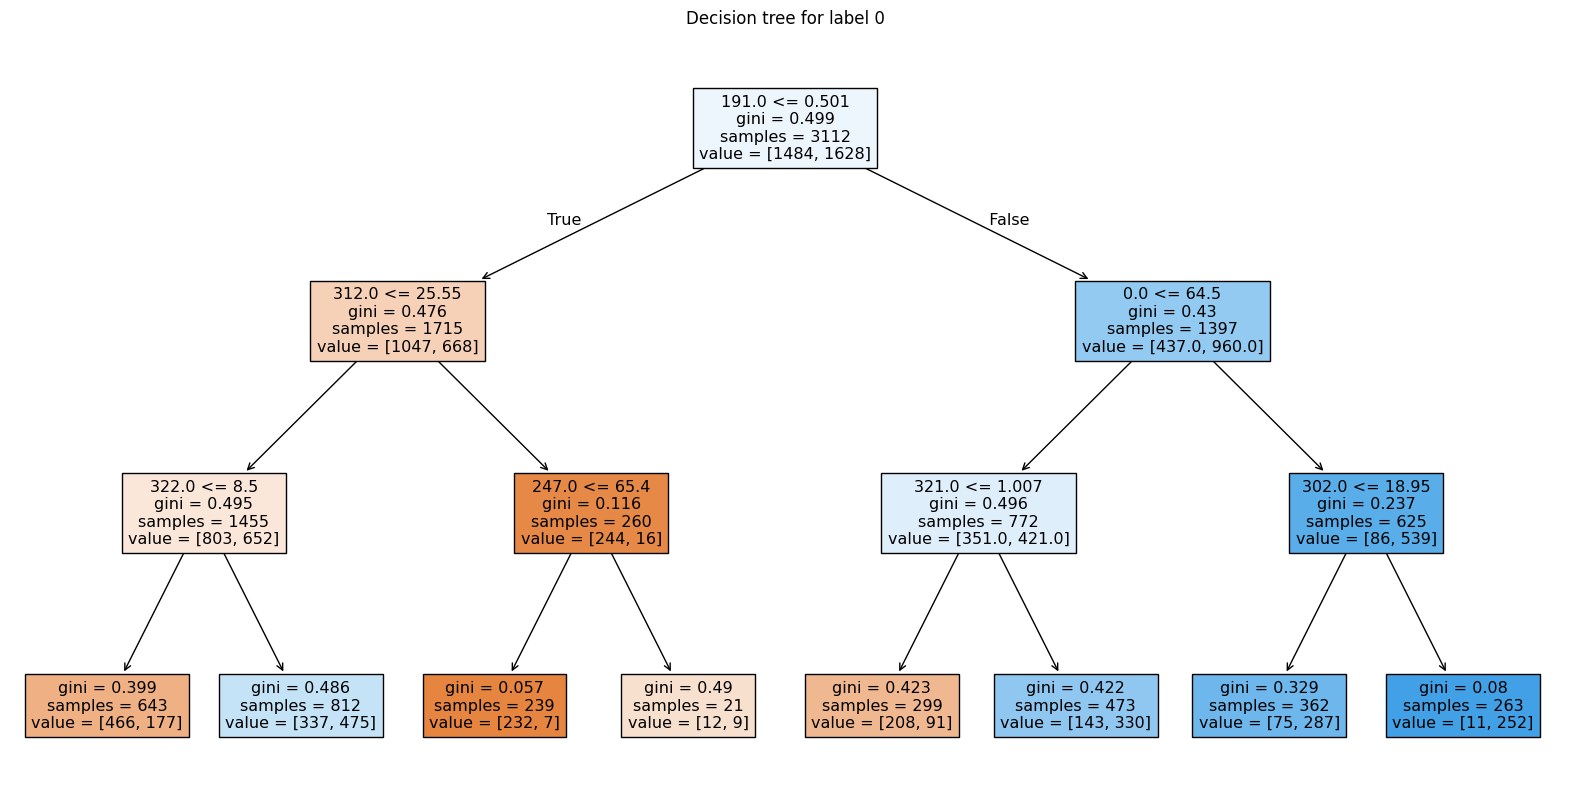

In [55]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
feature_names = np.linspace(0,342,343)
class_labels = ["pompe -4 mod","pompe +2 mod","pompe +27 mod","cogen mod","boilers mod"]
plot_tree(clf.estimators_[0], filled=True, feature_names=feature_names)
plt.title("Decision tree for label 0")
plt.show()

## predictions ##

In [56]:
def predict(X,clf):
    input = X
    input = input.reshape(1, -1)
    y_pred = clf.predict_proba(input)
    return y_pred
y = y_test[0]
y_pred = predict(X_test[0],clf)
print(f"y_pred {y_pred}")
print(f"y {y}")

probas = clf.predict_proba(X_test)

y_pred [array([[0.72472784, 0.27527216]]), array([[0., 1.]]), array([[0.08695652, 0.91304348]]), array([[0.99678146, 0.00321854]])]
y [0. 1. 1. 0.]


## calcul losses ##

In [57]:
from sklearn.metrics import f1_score, hamming_loss
binary_preds = []
for x in X_test:
    input = x.reshape(1, -1)
    pred = clf.predict(input)  # Liste de 11 tableaux (1D), un par classe
    binary_preds.append(pred[0])
binary_preds = np.array(binary_preds)
print("F1 score (micro):", f1_score(y_test, binary_preds, average='micro'))
print("Hamming loss:", hamming_loss(y_test, binary_preds))

F1 score (micro): 0.9339384770549672
Hamming loss: 0.08419023136246787


In [58]:
# Sauvegarde
joblib.dump(clf, "modele_multioutput.pkl")

['modele_multioutput.pkl']

## test d'utilisations ##

In [59]:
#test
test = torch.load('./dataset/25_07_2016_45_00.pt',weights_only=False)
X = test['input']
X = X.reshape(-1)
X = X.numpy()
print(np.shape(X))
clf_reloaded = joblib.load("modele_multioutput.pkl")
y_pred = predict(X,clf_reloaded)
print(f"y {test['output']}")
print(f"y_pred {y_pred}")

(343,)
y tensor([0.5012, 0.7024, 0.6995, 0.4666])
y_pred [array([[0.41502463, 0.58497537]]), array([[6.52103032e-04, 9.99347897e-01]]), array([[0.00135777, 0.99864223]]), array([[0.99678146, 0.00321854]])]


# test sortie de modulations


In [61]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# y_train_frac : (n_samples, 12) dans [0,1]  (duty-cycle moyen ou 0/1)
reg = MultiOutputRegressor(
    DecisionTreeRegressor(max_depth=3, min_samples_leaf=20, random_state=0)
).fit(X_train, y_train_frac)

y_hat = reg.predict(X_test).clip(0, 1)         # proba/% par sortie
mae  = mean_absolute_error(y_test_frac, y_hat)
rmse = mean_squared_error(y_test_frac, y_hat)
print(f"mae {mae}")
print(f"rmse {rmse}")

joblib.dump(reg, "modele_multioutput_regression.pkl")



mae 0.09721163584388087
rmse 0.024744433919784294


['modele_multioutput_regression.pkl']

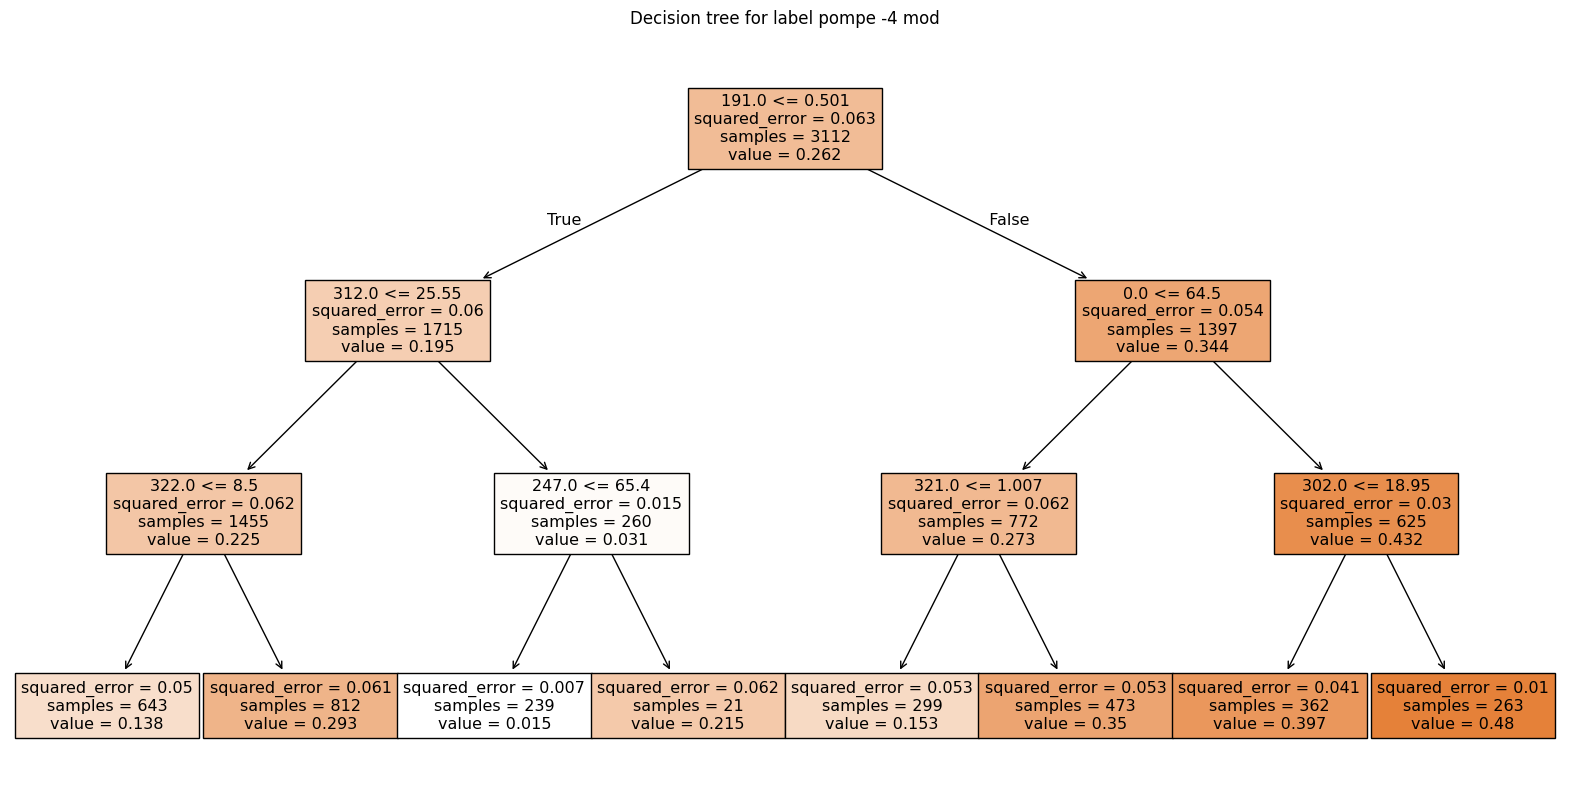

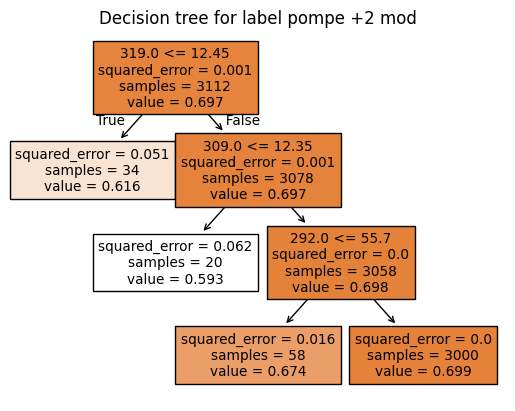

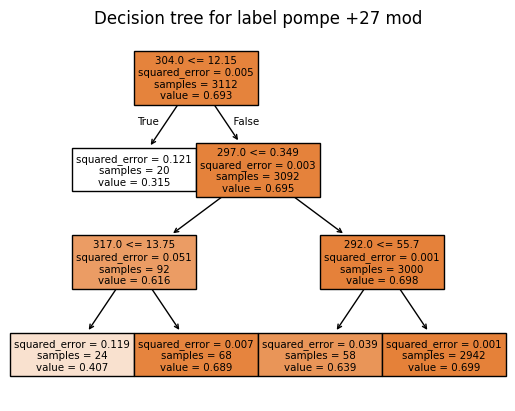

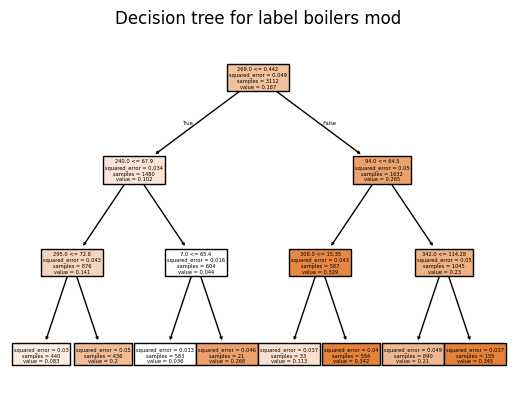

In [66]:
plt.figure(figsize=(20,10))
feature_names = np.linspace(0,342,343)
class_labels = ["pompe -4 mod","pompe +2 mod","pompe +27 mod","boilers mod"]
for i in range(4):
    plot_tree(reg.estimators_[i], filled=True, feature_names=feature_names)
    plt.title(f"Decision tree for label {class_labels[i]}")
    plt.show()

In [79]:
#test
def predict(X,reg):
    input = X.reshape(1, -1)
    y_pred = reg.predict(input)
    return y_pred

test = torch.load('./dataset/25_07_2016_00_00.pt',weights_only=False)
print(input)
reg = joblib.load("modele_multioutput_regression.pkl")
y_pred = predict(X,reg)
print(f"y {test['output']}")
print(f"y_pred {y_pred}")

[[ 62.600006  65.399994  59.200012  65.600006  64.20001   65.
   64.        61.600006  64.399994  64.20001   71.         0.
    0.7024     0.6982     0.4666    62.600006  64.80002   59.200012
   65.        63.399994  65.        63.399994  59.600006  63.80002
   64.20001   71.         0.         0.7024     0.6982     0.4666
   62.600006  65.399994  59.200012  65.600006  64.20001   65.
   64.        60.200012  63.80002   64.20001   71.         0.
    0.7024     0.6982     0.4666    62.600006  65.399994  59.80002
   65.600006  63.399994  65.        64.        59.600006  63.80002
   64.20001   71.         0.         0.7024     0.6982     0.4666
   62.600006  64.80002   59.80002   65.        64.20001   65.
   63.399994  59.600006  63.80002   64.20001   71.         0.
    0.7024     0.6982     0.4666    62.        64.80002   59.200012
   65.        63.399994  65.        63.399994  58.80002   63.80002
   64.20001   71.         0.         0.7024     0.6982     0.4666
   62.600006  64.80002   5